In [8]:
import gzip

# map sample to individual
ind_id_to_sample_id = dict()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    for line in f:
        pieces = line.strip().split(',')
        ind_id_to_sample_id[pieces[2]] = pieces[1]
        
# pull samples present in sv file
variant_file = '../other_sv_calls/lumpy_svs/lp.b12_19.vcf.gz'

with gzip.open(variant_file, 'rt') as f:
    # skip header
    header = '##'
    while header.startswith('##'):
        header = next(f)
        
    header = header.strip().split('\t')[9:]
    sample_id_to_index = dict([(x, i) for i, x in enumerate(header)])
    ind_id_to_index = dict([(k, sample_id_to_index[v]) for k, v in ind_id_to_sample_id.items() if v in sample_id_to_index])
    
# pull families from ped file
ped_file = '../data/160826.ped'
family_to_inds = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]
        fkey = (fam_id, m_id, f_id)
        if child_id in ind_id_to_index and f_id in ind_id_to_index and m_id in ind_id_to_index:
            if fkey not in family_to_inds:
                family_to_inds[fkey] = [m_id, f_id]
            family_to_inds[fkey].append(child_id)
family_to_indices = dict([(k, [ind_id_to_index[x] for x in v]) for k, v in family_to_inds.items()])
families = sorted(family_to_indices.keys())

print('Num families', len(family_to_indices))
print('Num individuals', len(sum(family_to_indices.values(), [])))

Num families 450
Num individuals 1967


In [10]:
with open('../split_gen/chr.22.gen.samples.txt', 'r') as f:
    ind_ids = [line.strip() for line in f]
ind_id_to_new_index = dict([(ind_id, i) for i, ind_id in enumerate(ind_ids)])
family_to_new_indices = dict([(k, [ind_id_to_new_index[x] for x in v]) for k, v in family_to_inds.items()])
m = max(ind_id_to_new_index.values())+1
print(m)

4610


In [58]:
import numpy as np

parent_indices = np.asarray([family_to_indices[f][:2] for f in families])
print(parent_indices.shape)

(415, 2)


In [54]:
# pull positions
snp_positions = [[] for i in range(23)]
with gzip.open(variant_file, 'rt') as f, open('lp.b12_19.inherited_dels.txt', 'w+') as outf:
    # skip header
    header = '##'
    while header.startswith('##'):
        header = next(f)
        
    header = header.strip().split('\t')
        
    for i, line in enumerate(f):
        if '<DEL>' in line:
            pieces = line.strip().split('\t', 3)
            chrom = None if pieces[0] == 'X' or pieces[0] == 'Y' or pieces[0] == 'MT' else int(pieces[0])
            start, end = int(pieces[1]), int(pieces[2])
            
            if chrom is not None:
                snp_positions[chrom].append(start)
                snp_positions[chrom].append(end)
        if i%100000 == 0:
            print(i, [len(x) for x in snp_positions])

0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
100000 [0, 126550, 5418, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
200000 [0, 126550, 124770, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
300000 [0, 126550, 126676, 77450, 51218, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
400000 [0, 126550, 126676, 77450, 156030, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
500000 [0, 126550, 126676, 77450, 158736, 68846, 64380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
600000 [0, 126550, 126676, 77450, 158736, 68846, 124366, 69470, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
700000 [0, 126550, 126676, 77450, 158736, 68846, 124366, 124874, 59846, 30342, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
800000 [0, 126550, 126676, 77450, 158736, 68846, 124366, 124874, 59846, 46824, 90122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
900000 [0, 126550, 126676, 77450, 158736, 68846, 124366, 124874, 59846, 46824, 163624, 51236, 0, 0, 0, 0, 0, 0, 

In [64]:
snp_positions = [sorted(x) for x in snp_positions]
pos_to_index = [dict([(x, i) for i, x in enumerate(p)]) for p in snp_positions]
deletions = [np.zeros((m, len(p))) for p in snp_positions]

In [82]:
import gzip

# load lumpy deletions
variant_file = 'lp.b12_19.vcf.gz'

gen_to_code = {'0/0': 0, '0/1': 1, '1/1': 2, './.': -1}

num_dels = [0 for i in range(23)]
with gzip.open(variant_file, 'rt') as f:
    # skip header
    header = '##'
    while header.startswith('##'):
        header = next(f)
        
    header = header.strip().split('\t')
        
    for i, line in enumerate(f):
        if '<DEL>' in line:
            pieces = line.strip().split('\t')
            chrom = None if pieces[0] == 'X' or pieces[0] == 'Y' or pieces[0] == 'MT' else int(pieces[0])
            start, end = int(pieces[1]), int(pieces[2])
            
            if chrom is not None:
                start_index, end_index = pos_to_index[chrom][start], pos_to_index[chrom][end]

                gens = np.asarray([gen_to_code[g[:3]] for g in pieces[9:]])
                
                # choose families with a deletion in at least one parent
                fkeys = [families[x] for x in np.where(np.sum(gens[parent_indices]>0, axis=1) > 0)[0]]
                
                for f in fkeys:
                    famgens = gens[family_to_indices[f]]
                    # choose families with a deletion in at least one child
                    if np.sum(famgens[2:]>0)>0:
                        for index, gen in zip(family_to_new_indices[f], famgens):
                            deletions[chrom][index, start_index:(end_index+1)] = gen
        
        if i%100000 == 0:
            print(i, num_dels)


0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
100000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
200000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
300000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
400000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
500000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
600000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
700000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
800000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
900000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1000000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1100000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1200000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1

In [89]:
chrom = 22
d = deletions[chrom]
indices = np.where(np.sum(d, axis=0)> 0)[0]
d = d[:, indices]
print(d.shape)

(4610, 35362)


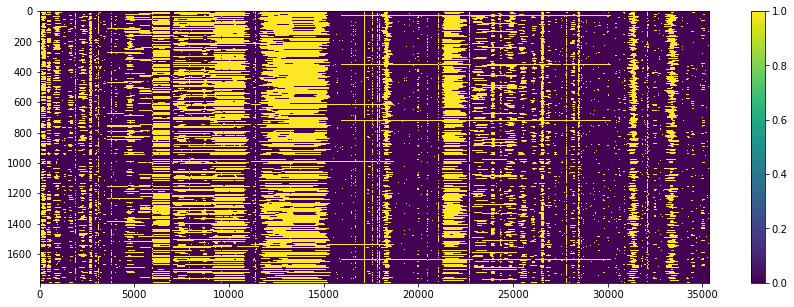

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.imshow(d[np.sum(d, axis=1)>0, :], aspect='auto')
plt.colorbar()
plt.show()

In [98]:
import scipy.sparse as sparse
for chrom in range(14, 23):
    d = deletions[chrom].astype(int)
    print(d.shape)
    d = sparse.csr_matrix(d)
    sparse.save_npz('lumpy_svs/chrom%d_deletions' % chrom, d)
    sp = np.asarray(snp_positions[chrom], dtype=int)
    print(sp.shape)
    np.save('lumpy_svs/chrom%d_positions' % chrom, sp)

(4610, 73208)
(73208,)
(4610, 39972)
(39972,)
(4610, 88888)
(88888,)
(4610, 68454)
(68454,)
(4610, 44476)
(44476,)
(4610, 94864)
(94864,)
(4610, 34372)
(34372,)
(4610, 46408)
(46408,)
(4610, 35946)
(35946,)


In [12]:
# pull positions
d_lengths = [[] for i in range(23)]
with gzip.open(variant_file, 'rt') as f:
    # skip header
    header = '##'
    while header.startswith('##'):
        header = next(f)
        
    header = header.strip().split('\t')
        
    for i, line in enumerate(f):
        if '<DEL>' in line:
            pieces = line.strip().split('\t', 3)
            chrom = None if pieces[0] == 'X' or pieces[0] == 'Y' or pieces[0] == 'MT' else int(pieces[0])
            start, end = int(pieces[1]), int(pieces[2])
            
            if chrom is not None:
                d_lengths[chrom].append(end-start)
        if i%100000 == 0:
            print(i, [len(x) for x in d_lengths])

0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


KeyboardInterrupt: 

In [11]:
import math

chrom = 1

dl = d_lengths[chrom]
plt.figure(figsize=(15, 5))
base = 1.4
max_length = max(dl) 
min_length = min(dl) 
print('min length', min(dl) , 'max length', max(dl) , 'num', len(dl))

plt.hist(dl, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.gca().set_xscale("log")
plt.show()

NameError: name 'd_lengths' is not defined